## ECE-UY 4563 Intro to Machine Learning Final Project - Dog Breed Classification (Unused Version)

## This version adds augmented pictures to training set and tests with different dropout possibilities. However, it is proved that both augmentation and dropout drecrese our model accuracy, so these version is not used any more but archived
* Presented by: Eren Tuksal(et2179@nyu.edu) and James Zhang(hz2852@nyu.edu)

In this project, we aim to develop a convolutional neural network capable of identifying 120 different dog breeds. The primary training dataset includes over 10,000 images of dogs captured from various angles and in diverse scenes. Additionally, there is a test dataset that includes not only dog images but also images of non-dog subjects, allowing us to evaluate the model's ability to differentiate between dog and non-dog images.



## Import Packages and ResNet18
The image processor from ResNet18 is loaded, and the classsification model will be used for transfer learning

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import skimage
from sklearn import linear_model, preprocessing
from transformers import AutoImageProcessor, AutoModelForImageClassification
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-18") # Load the image processor from ResNet18
model = AutoModelForImageClassification.from_pretrained("microsoft/resnet-18").to(device) # Load the classification model

Using device: cuda


## Dog Time - Draw some dog pictures

                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever
(10222, 2)


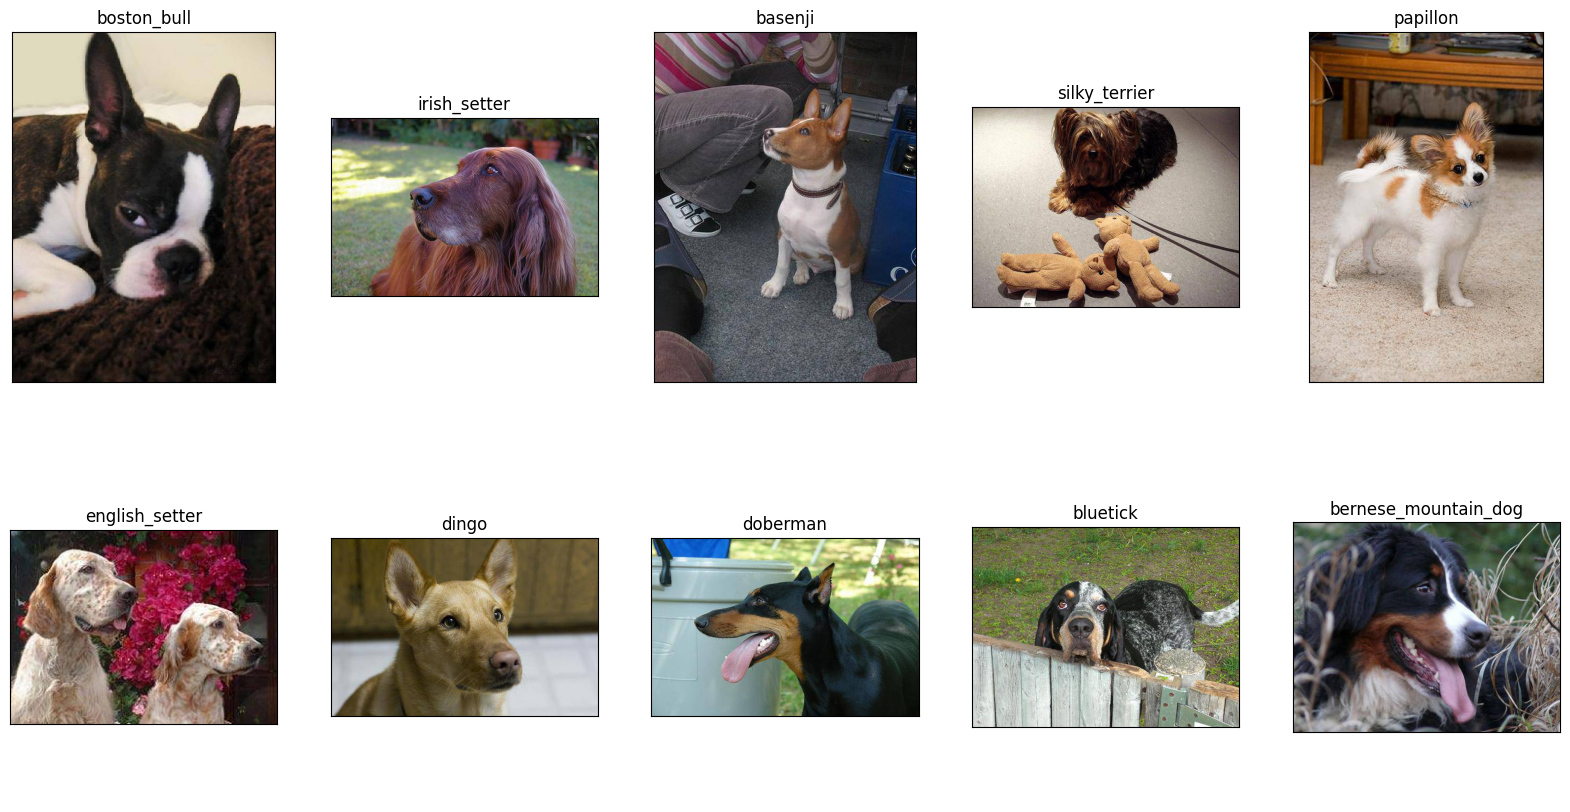

In [2]:
# load the labels
df = pd.read_csv('labels.csv')
print(df.head())
print(df.shape)

# display images function
def disp_image(im):
    # Color image.
    im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255
    im1 = im1.astype(np.uint8)
    plt.imshow(im1)
    
    # Remove axis
    plt.xticks([])
    plt.yticks([])
    
plt.subplots(figsize=(20, 10))
plt.axis('off')
for i in range(10):
    plt.subplot(2, 5, i+1)
    k = np.random.randint(low=0,high=df.shape[0])
    fname = 'train/' + df['id'][k] + '.jpg'
    im_color = skimage.io.imread(fname)
    disp_image(im_color)
    plt.title(df.loc[k, 'breed'])


## Image Preprocess
Use the image processor from ResNet18 loaded before to preprocess the pictures
* Resize all input pictures into 224*224 pixels
* Transform image files into a Pytorch tensor 
* Put all tensors (images) into a list called inputs

In [3]:
from torchvision import transforms
from PIL import Image
import torch
import numpy as np
import skimage.io

# Convert dog breeds into numbers
le = preprocessing.LabelEncoder()
df['breed'] = le.fit_transform(df['breed'])

# Define data augmentation transformations
augmentation_transforms = transforms.Compose([
    transforms.ToPILImage(),               # Convert numpy array to PIL image
    transforms.RandomHorizontalFlip(p=0.5),  # Flip images horizontally with a 50% chance
    transforms.RandomRotation(degrees=15),  # Rotate images by up to 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, etc.
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),  # Crop and resize
    transforms.ToTensor()                  # Convert back to tensor
])

# Initialize lists for augmented data and labels
inputs = []  # List to store image tensors
all_labels = []  # List to store corresponding labels

# Loop through each image in the dataset
for im in range(df.shape[0]):
    fname = 'train/' + df['id'][im] + '.jpg'
    label = df['breed'][im]
    
    # Load image
    input_image = skimage.io.imread(fname)
    
    # Add original image to inputs
    original_tensor = image_processor(input_image, return_tensors="pt")["pixel_values"][0]
    inputs.append(original_tensor)
    all_labels.append(label)
    
    # Randomly decide whether to augment
    random_num = np.random.rand()
    if random_num > 0.8:
        # Apply augmentations
        augmented_image = augmentation_transforms(input_image)
    
        # Add augmented image and corresponding label
        inputs.append(augmented_image)
        all_labels.append(label)

# Convert the lists to tensors
input_batch = torch.stack(inputs).to(device)
labels = torch.tensor(all_labels, dtype=torch.long).to(device)

# Print dataset statistics
print(f"Dataset now contains {len(all_labels)} samples.")
print(f"Shape of input_batch: {input_batch.shape}")
print(f"Number of unique labels: {len(torch.unique(labels))}")

Dataset now contains 12218 samples.
Shape of input_batch: torch.Size([12218, 3, 224, 224])
Number of unique labels: 120


## Use the ResNet directly classify the image (WIP)

In [4]:
## USE RESNET-18 to determine the breed
# part_labels = labels[19]
# part_inputs = inputs[19]
# with torch.no_grad():  # No need to compute gradients during inference
#     output = model(part_inputs)
#     logits = output.logits

# print(logits.shape)
# probabilities = torch.nn.functional.softmax(logits, dim=-1)

# # Find the top 3 classes and their probabilities
# ntop = 3
# top_prob, top_catid = torch.topk(probabilities, ntop)

# # Convert to numpy
# top_prob = top_prob.numpy()
# top_catid = top_catid.numpy()
# print(top_catid)
# id2label = model.config.id2label
# print(id2label[top_catid[0][0]])

In [5]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
torch.cuda.empty_cache()
import gc
gc.collect()

# TODO
xtr, xts, ytr, yts = train_test_split(input_batch,labels,test_size=0.15)
print(xtr.shape)
print(xts.shape)

xtr = torch.tensor(xtr, dtype=torch.float32).to(device) # Ensure input is float tensor
xts = torch.tensor(xts, dtype=torch.float32).to(device)
ytr = torch.tensor(ytr, dtype=torch.int64).to(device)     # Ensure labels are integer tensor
yts = torch.tensor(yts, dtype=torch.int64).to(device)

# Create a TensorDataset
train_dataset = TensorDataset(xtr, ytr)
test_dataset = TensorDataset(xts, yts)

# Create a DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

torch.Size([10385, 3, 224, 224])
torch.Size([1833, 3, 224, 224])


C:\Users\TUTU\AppData\Local\Temp\ipykernel_9256\1694363449.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xtr = torch.tensor(xtr, dtype=torch.float32).to(device) # Ensure input is float tensor
C:\Users\TUTU\AppData\Local\Temp\ipykernel_9256\1694363449.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xts = torch.tensor(xts, dtype=torch.float32).to(device)
C:\Users\TUTU\AppData\Local\Temp\ipykernel_9256\1694363449.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ytr = torch.tensor(ytr, dtype=torch.int64).to(device)     # Ensur

## Transfer Learning 
Modify loaded ResNet18. We will substitute the last output layer with our model.
* Change the output dimension to 120, number of breeds in dataset
* Freeze all layers except the last layer



In [6]:
# import torch.optim as optim
# # Modify the output layer of ResNet model
# num_classes = 120

# # Add a custom classifier with dropout
# model.classifier = nn.Sequential(
#     nn.Flatten(start_dim=1, end_dim=-1),  
#     nn.Sequential(
#         nn.Dropout(p=0.55), 
#         nn.Linear(in_features=512, out_features=num_classes, bias=True)  
#     )
# )

# # Freeze all layers except the last layer
# for param in model.parameters():
#     param.requires_grad = False

# # Unfreeze the newly added classifier (fc layer)
# for param in model.classifier.parameters():
#     param.requires_grad = True

# model = model.to(device)

# # Print the modified model to verify
# print(model)

# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss().to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# Re-train the model

In [7]:
import torch.optim as optim

# Lists to store training and testing accuracy for each epoch
train_accuracy_history = []
test_accuracy_history = []
loss_history = []

epochs = 20
dropoutP = [0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66]
num_classes = 120
for dp in dropoutP:
  print(f'This training uses dropout value {dp}')
  # Add a custom classifier with dropout
  model.classifier = nn.Sequential(
      nn.Flatten(start_dim=1, end_dim=-1),  
      nn.Sequential(
          nn.Dropout(p=dp), 
          nn.Linear(in_features=512, out_features=num_classes, bias=True)  
      )
  )
  # Freeze all layers except the last layer
  for param in model.parameters():
      param.requires_grad = False

  # Unfreeze the newly added classifier (fc layer)
  for param in model.classifier.parameters():
      param.requires_grad = True

  model = model.to(device)
  
  # Define loss function and optimizer
  criterion = nn.CrossEntropyLoss().to(device)
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  
  # Training loop
  for epoch in range(epochs):
    torch.cuda.empty_cache()
    # Train over epoch
    model.train()
    correct = 0
    total = 0
    epoch_loss = 0
    for (data,target) in train_loader:
      data, target = data.to(device), target.to(device) 
      optimizer.zero_grad()
      outputs = model(data)
      loss = criterion(outputs.logits, target)
      loss.backward()
      optimizer.step()
      
      _, predicted = torch.max(outputs.logits, 1) # find index of largest output on each row
      total += target.size(0)
      correct += (predicted == target).sum().item()
      epoch_loss += loss.item()
      del data, target, outputs, loss
      gc.collect()
      
    train_accuracy = 100 * correct / total
    train_accuracy_history.append(train_accuracy)
    average_loss = epoch_loss / len(train_loader)
    loss_history.append(average_loss)

    # Test over epoch
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.logits, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    test_accuracy = 100 * correct / total
    test_accuracy_history.append(test_accuracy)
    
    # TODO:  Print accuracy
    print(f'Epoch [{epoch+1}/{epochs}], loss history: {average_loss}')
    print(f'Train Accuracy: {train_accuracy}%')
    print(f'Test Accuracy:{test_accuracy}%')
    print()

  print("Finished Training")




This training uses dropout value 0.5
Epoch [1/20], loss history: 3.204632742221539
Train Accuracy: 27.260471834376503%
Test Accuracy:59.192580469176214%



KeyboardInterrupt: 